In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression as Logistic
# from sklearn.metrics import accuracy_score, label_ranking_average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter, OrderedDict
import os

from utils.utils import *
from utils.utils_baseline_svm import *

from utils.kwargs_file import kwargs_lin_data_init, kwargs_svm, kwargs_logistic

In [2]:
# call for linear model
# change data preprocessing hyper-parameters
kwargs_lin_data_init.mk_ngrams = True
kwargs_lin_data_init.char_filter = 100
kwargs_lin_data_init.ngram_filter = 10

kwargs_lin_data_init.use_suggestions = False

# for writing the results to file
sub_folder = 'svm_results/'

# summary_path = 'SVM_hyperparameter_summary_suggest_08_WITH_NGRAMS_near_NO_FILTER.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_08_only_BOC_6_1.csv'
# summary_path = 'SVM_hyperparameter_summary_suggest_08_WITH_NGRAMS_6_1.csv'
# summary_path = 'SVM_hyperparameter_summary_no_suggest_WITH_NGRAMS_near_NO_FILTER.csv'
# summary_path = 'SVM_hyperparameter_summary_no_suggest_only_BOC_6_1.csv'
summary_path = 'SVM_hyperparameter_summary_no_suggest_WITH_NGRAMS_6_1.csv'
summary_path = sub_folder + summary_path

In [ ]:
# vectorizer transforms dict into sparse matrix
v = DictVectorizer(sparse=True)

x_train, x_val, y_train, y_val, allowed_ngrams = \
    data_load_preprocess(**kwargs_lin_data_init)

In [ ]:
# x_train, x_val, y_train, y_val, allowed_ngrams = \
#     data_load_preprocess(**{**kwargs_lin_data_init, 
#                             **{'linear_counters': False}})

# keep_first_k_chars(input=x_train, k=4, 
#                    model='linear', 
#                    ngram_width=kwargs_lin_data_init.ngram_width, 
#                    mk_ngrams=kwargs_lin_data_init.mk_ngrams, 
#                    allowed_ngrams=allowed_ngrams)

In [ ]:
# create a sparse X matrix with character and n-grams features
X_train = v.fit_transform(x_train)
X_val = v.transform(x_val)

# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html

print('X_train (sparse) matrix, of size {} by {} has been created.'
      .format(X_train.get_shape()[0], X_train.get_shape()[1]))  # vectorized

svm_clf = svm.SVC(**kwargs_svm)

In [ ]:
svm_clf.fit(X_train, y_train)

In [ ]:
pred = svm_clf.predict(X_val)

# http://scikit-learn.org/stable/modules/svm.html
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# print(accuracy_score(y_val, pred))
# equivalent to:
print('Accuracy on validation set is {:.3f}'.format(svm_clf.score(X_val, y_val)))
# print(pred[:10])

# array to hold log probabilities (takes a bit longer to calc)
pred_prob = svm_clf.predict_log_proba(X_val)
# makes y into array with the same shape as the log prob
y_val_dense = y_to_dense(y=y_val, 
                         classes=svm_clf.classes_)

In [ ]:
k = 5
'{:.3f} of observations has the correct class in the top {} prediction'.format(
    in_top_k(y_val_dense, pred_prob, k), k)

print('Mean Reciprocal Rank is {:.3f}'.format(mean_reciprocal_rank(y_val_dense, pred_prob)))

In [ ]:
# logistic regression

logistic_clf = Logistic(**kwargs_logistic)
logistic_clf.fit(X_train, y_train)

In [ ]:
pred_logistic = logistic_clf.predict(X_val)
print('Accuracy on validation set is {:.3f}'.format(svm_clf.score(X_val, y_val)))

In [ ]:
"""
Train multiple classifiers with different hyper-parameters.
"""

In [ ]:
k = 5  # for the top_k metric

summary_to_file = []

for kernel, degree in zip(
    ['linear', *['poly'] * 3, 'rbf', 'sigmoid'], 
    [3, *list(range(2, 2+3)), 3, 3]):
    for C in [0.01, 0.1, 1.0]: 
        for shrinking in [True, False]:
            kwargs_cur_params = {**kwargs_svm, 
                                 **{'kernel': kernel, 
                                    'degree': degree, 
                                    'C': C,
                                    'shrinking': shrinking}}
            
            # clearing all vars (just making sure)
            svm_cur = ''
            pred_cur = ''
            pred_prob_cur = ''
            y_val_dense_cur = ''
            cur_acc, cur_topk, cur_mrr = '', '', ''
            summary_cur_model, summary_dict = '', ''

            # create and fit model
            svm_cur = svm.SVC(**kwargs_cur_params)
            svm_cur.fit(X_train, y_train)
            # predictions
            pred_cur = svm_cur.predict(X_val)
            # log probabilities
            pred_prob_cur = svm_cur.predict_log_proba(X_val)
            # makes y into array with the same shape as the log prob
            # get dense y again, not sure if classes are always ordered the same
            y_val_dense_cur = y_to_dense(y=y_val, 
                                         classes=svm_cur.classes_)
            # collect evaluation metrics
            cur_acc, cur_topk, cur_mrr = \
                in_top_k(y_val_dense_cur, pred_prob_cur, 1), \
                in_top_k(y_val_dense_cur, pred_prob_cur, k), \
                mean_reciprocal_rank(y_val_dense, pred_prob_cur)
            
            summary_to_file.append(OrderedDict(
                sorted(tuple((k,v) for k,v in svm_cur.get_params().items() 
                             if k not in ['class_weight', 
                                          'cache_size', 
                                          'max_iter', 
                                          'random_state', 
                                          'tol', 
                                          'verbose'])) + \
                [('Accuracy', '{:.3f}'.format(cur_acc)), 
                 ('Mean Reciprocal Rank', '{:.3f}'.format(cur_mrr)), 
                 ('Top {}'.format(k), '{:.3f}'.format(cur_topk))]
            ))
            
            print('Model fitted: {}'.format(svm_cur))
            print('Accuracy on test set is {:.3f}'.format(cur_acc))
            print('{:.3f} of observations has the correct class in the top {} prediction'.format(
                cur_topk, k))
            print('Mean Reciprocal Rank is {:.3f}'.format(cur_mrr))

In [ ]:
results_df = pd.DataFrame(summary_to_file)
results_df.sort_values(by='Mean Reciprocal Rank', 
                       ascending=False, 
                       inplace=True)

results_df

In [ ]:
# save to file
results_df.to_csv(summary_path)

In [3]:
"""
Load training results from CSV files
"""

'\nLoad training results from CSV files\n'

In [4]:
# get a list of file names in sub_folder
summary_files = [fname
                 for fname 
                 in next(os.walk(sub_folder))][2]

summary_files = [sub_folder + fname 
                 for fname in summary_files]

In [5]:
results = []
for file in summary_files:
    data_table = pd.read_csv(file)
    row = OrderedDict()
    row['name'] = file.split('summary_')[1]  # split the file name
    row['Accuracy'] = data_table['Accuracy'][0]
    row['Mean Reciprocal Rank'] = data_table['Mean Reciprocal Rank'][0]
    row['kernel'] = data_table['kernel'][0]
    row['c'] = data_table['C'][0]
    results.append(row)

In [6]:
results_summary = pd.DataFrame(results)
results_summary = \
    results_summary.sort_values(by='Accuracy', ascending=False)

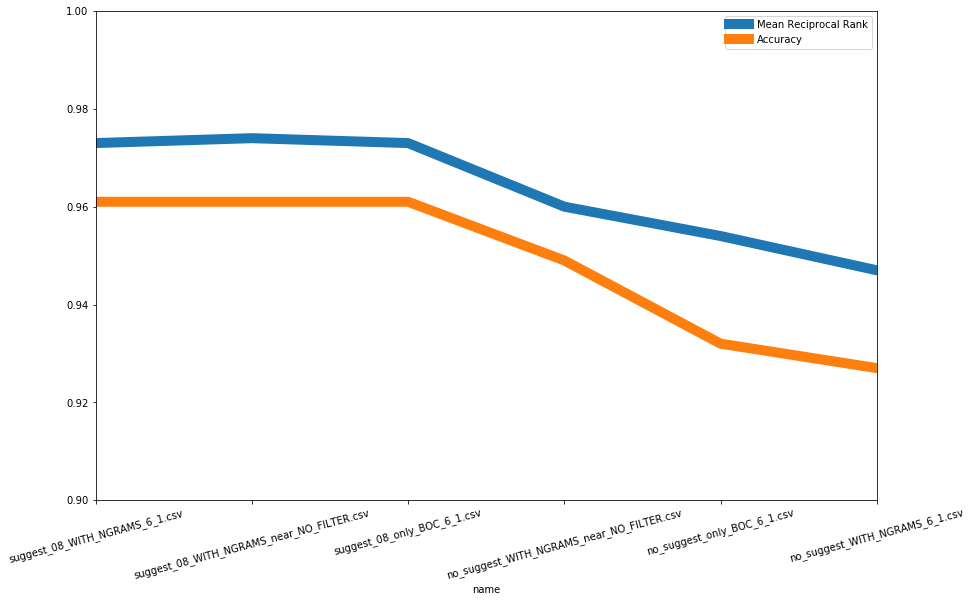

In [7]:
results_summary.plot(x='name', 
                     y=['Mean Reciprocal Rank', 
                        'Accuracy'], 
                     figsize=(14,9),
                     rot=15, 
                     ylim=(0.9, 1.0), 
                     linewidth=10, 
                     kind='line')